# Fluorescence Recovery After Photobleaching

In [2]:
#importing the required modules
import numpy as np #Numerical Python
import scipy #Scientific Python
from scipy.optimize import leastsq #for least squares fitting

%matplotlib notebook

import matplotlib
from matplotlib import pylab

import tiff_file #Ignore any warnings importing this may cause

## Specify location of data

In [3]:
#Now let's locate the data
data_directory = ".\\"
data_file = "video_1.tif"

## Identify where bleaching occurs

<IPython.core.display.Javascript object>


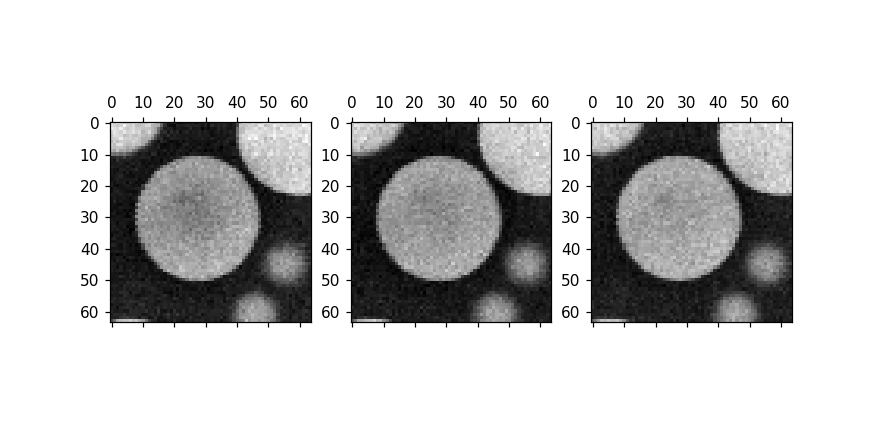

(624, 64, 64)


In [7]:
first_postbleach_frame = 56 #start counting at frame=0
all_frames = tiff_file.imread(data_directory+data_file)
postbleach_frame = all_frames[first_postbleach_frame]
fig,ax = pylab.subplots(1,3,figsize=(8,4))
ax[0].matshow(postbleach_frame,cmap=matplotlib.cm.gray, interpolation=None)
ax[1].matshow(all_frames[first_postbleach_frame+10],cmap=matplotlib.cm.gray, interpolation=None)
ax[2].matshow(all_frames[first_postbleach_frame+20],cmap=matplotlib.cm.gray, interpolation=None)


print(all_frames.shape)

<IPython.core.display.Javascript object>


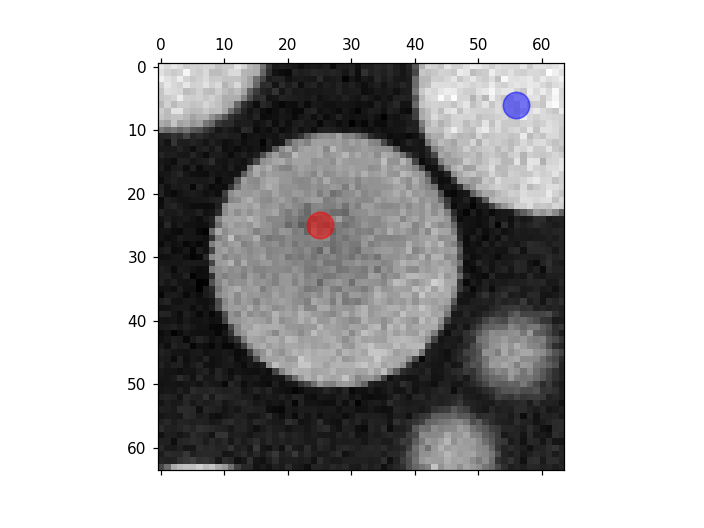

In [28]:
#Choose coordinates of the *center* of a bleached region
y_center_bleach = 25  # <------ you will need to change this for your data!
x_center_bleach = 25  # <------ you will need to change this for your data!

#Choose coordinates of the *center* of some background region
y_center_bg = 6   # <------ you will need to change this for your data
x_center_bg = 56# <------ you will need to change this for your data

#Plotting just to make sure the coordinates above are appropriate
fig,ax = pylab.subplots()
ax.invert_yaxis()
ax.matshow(postbleach_frame,cmap=matplotlib.cm.gray, interpolation=None)
ax.scatter(x_center_bleach, y_center_bleach, s=300, alpha=0.5, c='r') #Red circle in bleach area
ax.scatter(x_center_bg, y_center_bg, s=300, alpha=0.5, c='b') #Blue circle outside bleach region


<IPython.core.display.Javascript object>


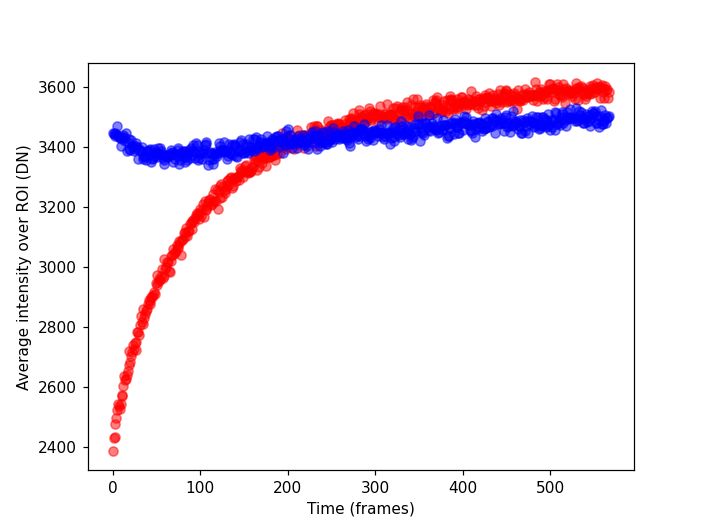

<IPython.core.display.Javascript object>


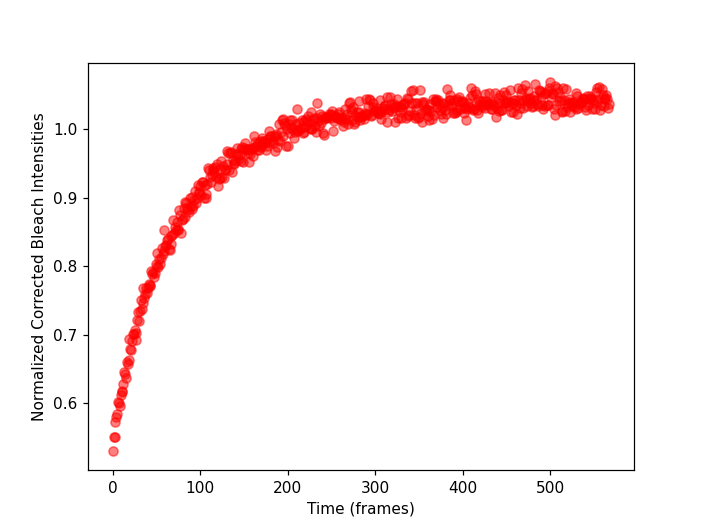

Text(0, 0.5, 'Normalized Corrected Bleach Intensities')

In [32]:
roi_size = 10

background_val = 1200

roi_bleach = np.array([[x_center_bleach-int(roi_size/2), x_center_bleach+int(roi_size/2)],
                       [y_center_bleach-int(roi_size/2), y_center_bleach+int(roi_size/2)]])
intensity_bleach_roi = all_frames[first_postbleach_frame:, 
                                  roi_bleach[1][0]:roi_bleach[1][1], 
                                  roi_bleach[0][0]:roi_bleach[0][1]].mean(axis=-1).mean(axis=-1)
pre_bleach_intensity = all_frames[:first_postbleach_frame, 
                                 roi_bleach[1][0]:roi_bleach[1][1], 
                                 roi_bleach[0][0]:roi_bleach[0][1]].mean()

roi_bg = np.array([[x_center_bg-int(roi_size/2), x_center_bg+int(roi_size/2)],
                   [y_center_bg-int(roi_size/2), y_center_bg+int(roi_size/2)]])
intensity_bg_roi = all_frames[first_postbleach_frame:,
                              roi_bg[1][0]:roi_bg[1][1], 
                              roi_bg[0][0]:roi_bg[0][1]].mean(axis=-1).mean(axis=-1)
pre_bg_intensity = all_frames[:first_postbleach_frame,
                              roi_bg[1][0]:roi_bg[1][1], 
                              roi_bg[0][0]:roi_bg[0][1]].mean()


BL_corr1 = (intensity_bleach_roi - background_val) / (intensity_bg_roi - background_val)
BL_corr2 = BL_corr1 / (pre_bleach_intensity / pre_bg_intensity)

fig,ax = pylab.subplots()
ax.plot(intensity_bleach_roi,'ro',alpha=0.5)
ax.plot(intensity_bg_roi,'bo',alpha=0.5)
ax.set_xlabel("Time (frames)")
ax.set_ylabel("Average intensity over ROI (DN)")


fig,ax = pylab.subplots()
ax.plot(BL_corr2,'ro',alpha=0.5)
ax.set_xlabel("Time (frames)")
ax.set_ylabel("Normalized Corrected Bleach Intensities")



In [33]:
def expFunc(params, time):
    return params[1]*(1-np.exp(-1.0*time/params[0])) + params[2]

def errorFunc(params, time, data):
    return data-expFunc(params,time)

[77.64329268  0.47556466  0.56328627]


<IPython.core.display.Javascript object>


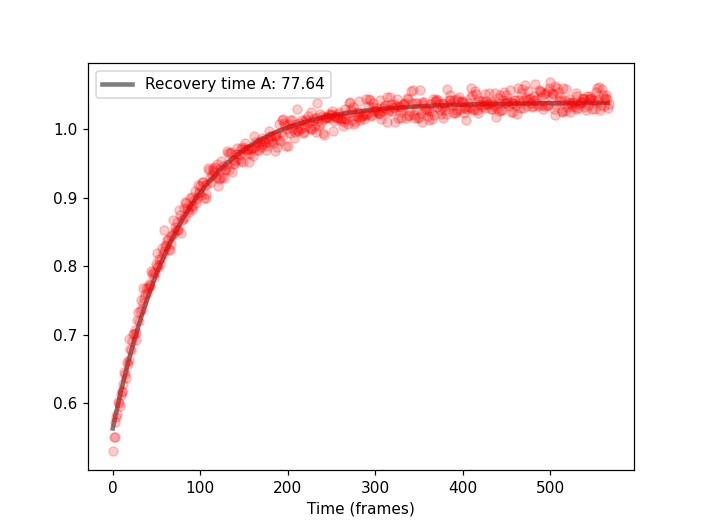

Text(0.5, 0, 'Time (frames)')

In [34]:
upperLimit = -1 #If -1, then no upper limit

bestFitA,flat = leastsq(errorFunc, [10,0.8,0.2], args=(np.arange(1,len(BL_corr2[:upperLimit])+1),BL_corr2[:upperLimit]))

print(bestFitA)

fig,ax = pylab.subplots()
times = np.arange(len(BL_corr2[:upperLimit]))
ax.plot(times, expFunc(bestFitA,times),'-k',lw=3,alpha=0.5,label="Recovery time A: %.2f" % bestFitA[0])
ax.plot(BL_corr2,'ro',alpha=0.2)
ax.legend(loc=0)
ax.set_xlabel("Time (frames)")